## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(env, state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary.
def add_to_dict(env, Q_dict, state):
    state1 = Q_state(state)

    if state1 not in Q_dict.keys():
        valid_act = valid_actions(env, state)
        for action in valid_act:
            Q_dict[state1][action] = 0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(env, Q_dict, state, time, min_epsilon, max_epsilon, decay_rate):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
        -decay_rate * time)
    z = np.random.random()

    if z > epsilon:
        state_key = Q_state(state)
        action = max(
            Q_dict[state_key], key=Q_dict[state_key].get
        )  # Exploitation: this gets the action corresponding to max q-value of current state
    else:
        action = random.choice(list(env.action_space(
            state)[0]))  # Exploration: randomly choosing and action

    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [('x-x-x-x-x-x-x-x-x', (7, 5)),
                  ('x-x-x-x-x-x-x-x-x', (7, 3)),
                  ('x-3-x-x-x-2-x-x-x', (3, 7)),
                  ('5-x-8-x-x-x-x-x-x', (1, 1))]


def initialise_tracking_states(States_track):
    for q_values in tracked_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [7]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
def save_tracking_states(States_track, Q_dict):
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [9]:
#initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [10]:
# max_epsilon = 1.0
# min_epsilon = 0.001
# decay_rate= 0.000001

# EPISODES = 5000000
# LR = 0.01                  
# GAMMA = 0.91

# log_threhold = 50000

# threshold = 500       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
# policy_threshold = 30000  #every these many episodes, the Q-dict will be updated


### Q-update loop ---write your code here

In [11]:
import pandas as pd
def convert_to_data_frame(model_name, data):
    df = pd.DataFrame.from_records(data)
    df['name'] = model_name
    return df

In [12]:
from itertools import product

hp_learning_rate = [0.01, 0.1]
hp_gamma = [0.8, 0.9]
hp_min_epsilon = [.001, 0.01]
decay_rate = [0.001, 0.0001, 0.00001, 0.000001]

hp_params = list(
    product(hp_learning_rate, hp_gamma, hp_min_epsilon, decay_rate))

In [13]:
def get_model_name(params):
    name = "lr_"+str(params[0]) + "_gamma_"+str(params[1])+"_min_epsilon_" + \
        str(params[2]) + "_decay_rate_"+str(params[3])
    return name

In [14]:
def plot_epsilon_decay(episodes, min_epsilon, max_epsilon, decay_rate):
    time = np.arange(0, episodes)
    epsilon = []
    for i in range(0, episodes):
        epsilon.append(min_epsilon +
                       (max_epsilon - min_epsilon) * np.exp(-decay_rate * i))
    plt.title("Epsilon Decay")
    plt.plot(time, epsilon)
    plt.show()

In [15]:
def plot_tracked_values(States_track):
    fig, axs = plt.subplots(1, 4, figsize=(15, 2))
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(States_track[tracked_value[0]][tracked_value[1]])))
        plt.subplot(1, 4, index+1)
        plt.plot(xaxis, np.asarray(
            States_track[tracked_value[0]][tracked_value[1]]))
        plt.title(tracked_value[0] +"_"+ "({},{})".format(tracked_value[1][0],tracked_value[1][1]))
    plt.show()

In [16]:
def q_learning(params, max_epsilon=1.0, episodes=50000, verbose=False):
    name = get_model_name(params)

    lr = params[0]
    gamma = params[1]
    min_epsilon = params[2]
    decay_rate = params[3]
    log_threshold = episodes * .01
    threshold = episodes * .01
    policy_threshold = episodes * 0.01

    print("learning_rate", lr)
    print("gamma", gamma)
    print("min_epsilon", min_epsilon)
    print("decay_rate", decay_rate)
    print("max_epsilon", max_epsilon)
    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("policy_threshold", policy_threshold)

    plot_epsilon_decay(episodes=episodes,
                       max_epsilon=max_epsilon,
                       min_epsilon=min_epsilon,
                       decay_rate=decay_rate)

    Q_dict = collections.defaultdict(dict)
    States_track = collections.defaultdict(dict)
    initialise_tracking_states(States_track)
    start_time = time.time()
    win = 0
    loss = 0
    tie = 0
    data = []

    for episode in range(episodes):
        # Start writing your code from the next line
        env = TicTacToe()

        curr_state = env.state
        is_game_finished = False

        add_to_dict(env, Q_dict, curr_state)

        reward = 0

        while not is_game_finished:
            current_state_key = Q_state(curr_state)

            curr_action = epsilon_greedy(env, Q_dict, curr_state, episode,
                                         min_epsilon, max_epsilon, decay_rate)

            next_state, reward, is_game_finished = env.step(
                curr_state, curr_action)

            next_state_key = Q_state(next_state)
            
            add_to_dict(env, Q_dict, next_state)

            if is_game_finished:
                if reward == 0:
                    tie += 1
                elif reward == -10:
                    loss += 1
                else:
                    win += 1
                Q_dict[current_state_key][curr_action] += lr * \
                    ((reward) - Q_dict[current_state_key][curr_action])
            else:
                # this gets the action corresponding to max q-value of next state
                max_next = max(Q_dict[next_state_key],
                               key=Q_dict[next_state_key].get)
                Q_dict[current_state_key][curr_action] += lr * (
                    (reward + (gamma * (Q_dict[next_state_key][max_next]))) -
                    Q_dict[current_state_key][curr_action])

            curr_state = next_state

        if (episode + 1) % log_threshold == 0:
            row = {}
            row["win"] = round(win / (episode + 1), 4)
            row["loss"] = round(loss / (episode + 1), 4)
            row["tie"] = round(tie / (episode + 1), 4)
            row["episode"] = episode + 1
            data.append(row)
            if verbose:
                print("Episode ", episode + 1, "Win: ", row["win"], "Loss: ",
                      row["loss"], "Tie: ", row["tie"])

        if ((episode + 1) % threshold) == 0:
            save_tracking_states(States_track, Q_dict)
            save_obj(States_track, 'States_tracked')

        # SAVING POLICY
        if ((episode + 1) % policy_threshold) == 0:
            save_obj(Q_dict, 'Policy')
            
    elapsed_time = time.time() - start_time
    save_obj(States_track, 'States_tracked')
    save_obj(Q_dict, 'Policy')
    plot_tracked_values(States_track)       
    print("elapsed_time", elapsed_time)
    return convert_to_data_frame(name, data), Q_dict, States_track

In [17]:
stats = None

In [18]:
def collect_stats(df):
    global stats
    if stats is not None:
        stats = pd.concat([stats, df], axis=0)
    else:
        stats = df
    return df

Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate_0.001
learning_rate 0.01
gamma 0.8
min_epsilon 0.001
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


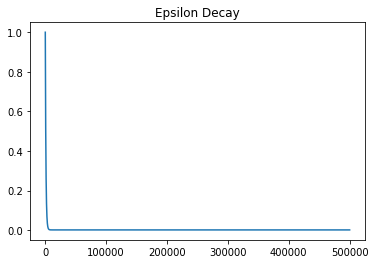

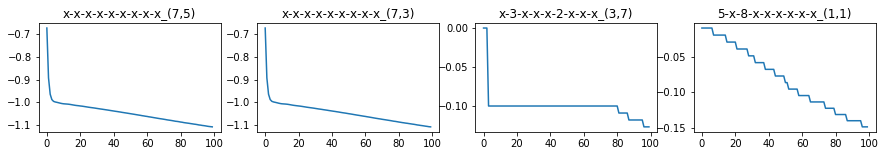

elapsed_time 404.9043221473694


,win,loss,tie,episode,name
98,0.3163,0.2521,0.4316,495000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...
99,0.3168,0.2519,0.4313,500000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate_0.0001
learning_rate 0.01
gamma 0.8
min_epsilon 0.001
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


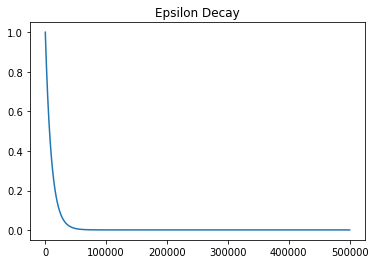

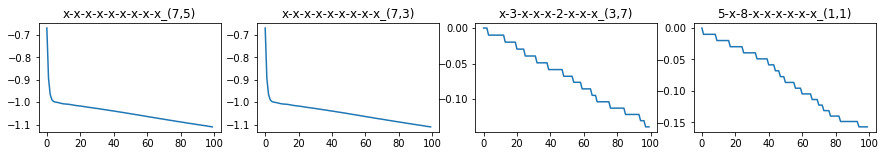

elapsed_time 308.9507842063904


,win,loss,tie,episode,name
98,0.3164,0.2514,0.4323,495000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...
99,0.3167,0.2513,0.4320,500000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate_1e-05
learning_rate 0.01
gamma 0.8
min_epsilon 0.001
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


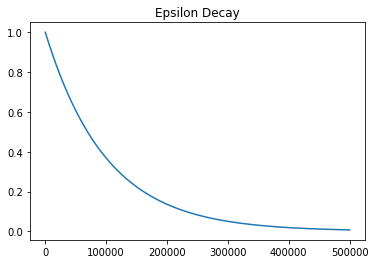

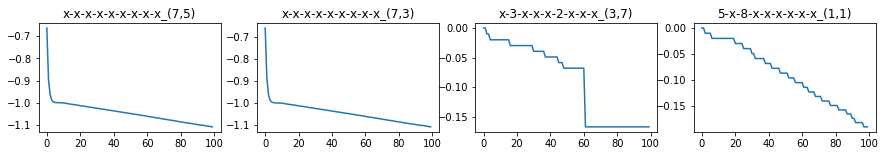

elapsed_time 375.2158739566803


,win,loss,tie,episode,name
98,0.3063,0.2568,0.4369,495000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...
99,0.3068,0.2567,0.4366,500000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate_1e-06
learning_rate 0.01
gamma 0.8
min_epsilon 0.001
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


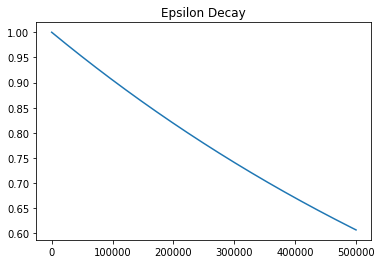

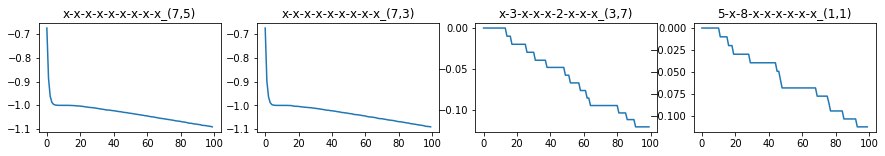

elapsed_time 382.3668098449707


,win,loss,tie,episode,name
98,0.2643,0.2782,0.4575,495000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...
99,0.2645,0.2781,0.4573,500000,lr_0.01_gamma_0.8_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_0.001
learning_rate 0.01
gamma 0.8
min_epsilon 0.01
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


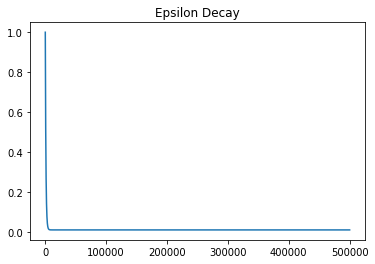

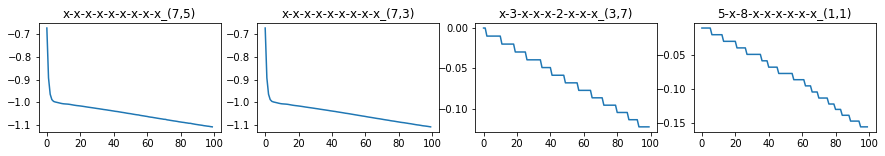

elapsed_time 324.6315689086914


,win,loss,tie,episode,name
98,0.3167,0.2511,0.4322,495000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...
99,0.3169,0.2509,0.4322,500000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_0.0001
learning_rate 0.01
gamma 0.8
min_epsilon 0.01
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


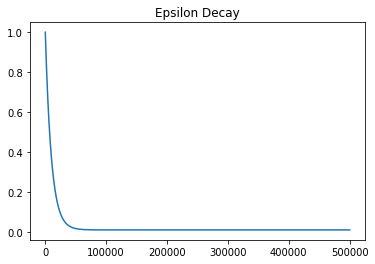

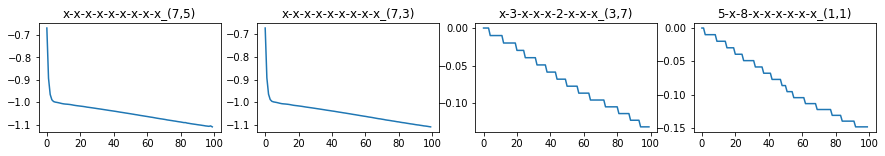

elapsed_time 380.0864930152893


,win,loss,tie,episode,name
98,0.3153,0.2523,0.4323,495000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...
99,0.3157,0.2522,0.4321,500000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_1e-05
learning_rate 0.01
gamma 0.8
min_epsilon 0.01
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


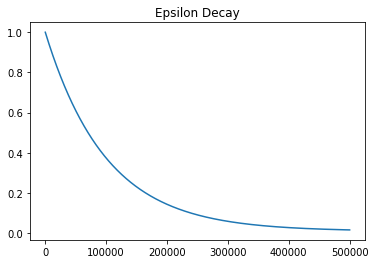

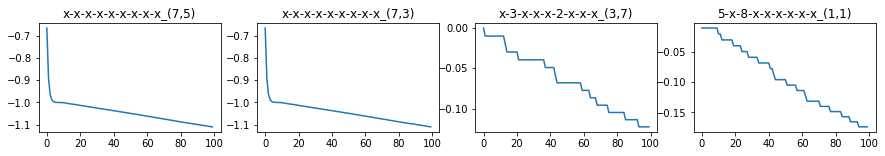

elapsed_time 322.59309792518616


,win,loss,tie,episode,name
98,0.3063,0.2567,0.4371,495000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...
99,0.3068,0.2565,0.4367,500000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_1e-06
learning_rate 0.01
gamma 0.8
min_epsilon 0.01
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


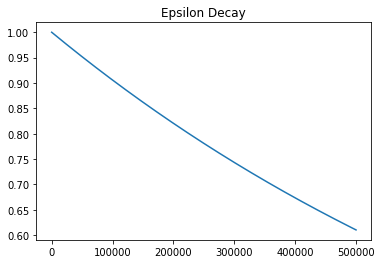

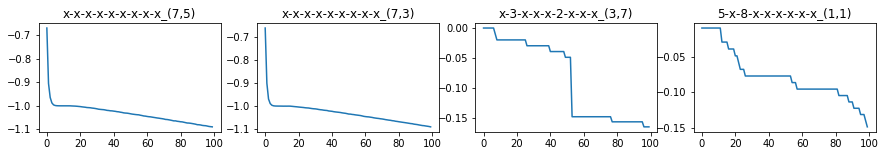

elapsed_time 403.35378885269165


,win,loss,tie,episode,name
98,0.2636,0.2773,0.4591,495000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...
99,0.2639,0.2772,0.4589,500000,lr_0.01_gamma_0.8_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate_0.001
learning_rate 0.01
gamma 0.9
min_epsilon 0.001
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


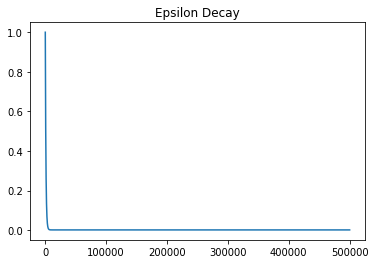

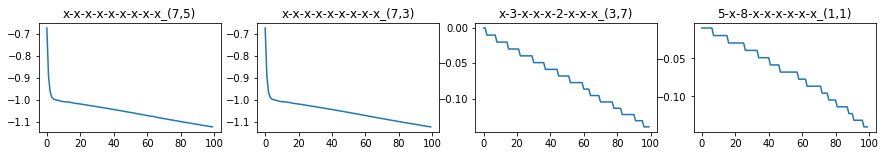

elapsed_time 294.50608706474304


,win,loss,tie,episode,name
98,0.3170,0.2524,0.4306,495000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...
99,0.3174,0.2523,0.4303,500000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate_0.0001
learning_rate 0.01
gamma 0.9
min_epsilon 0.001
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


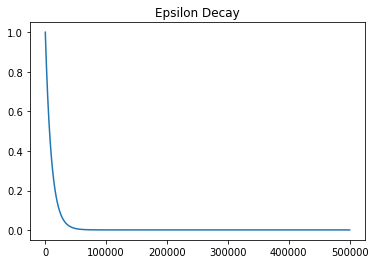

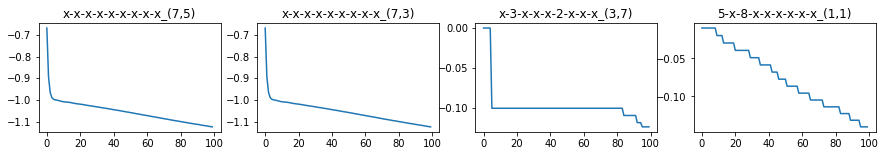

elapsed_time 302.19882011413574


,win,loss,tie,episode,name
98,0.3161,0.2516,0.4323,495000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...
99,0.3165,0.2515,0.4320,500000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate_1e-05
learning_rate 0.01
gamma 0.9
min_epsilon 0.001
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


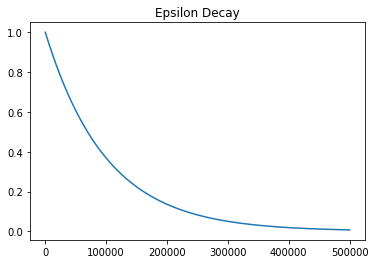

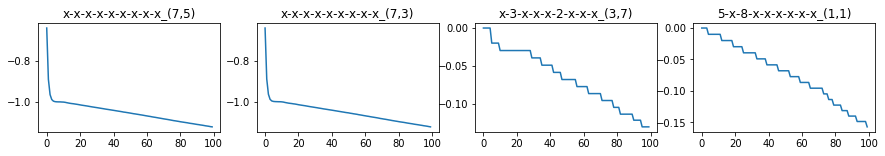

elapsed_time 318.707594871521


,win,loss,tie,episode,name
98,0.3056,0.2556,0.4388,495000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...
99,0.3061,0.2553,0.4386,500000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate_1e-06
learning_rate 0.01
gamma 0.9
min_epsilon 0.001
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


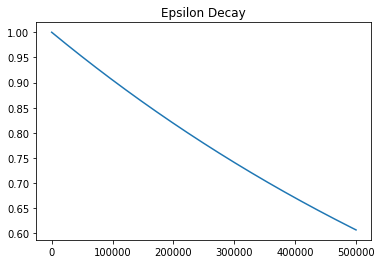

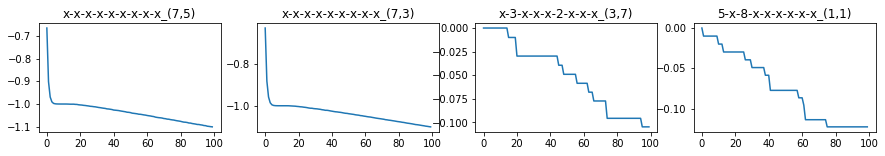

elapsed_time 394.7763919830322


,win,loss,tie,episode,name
98,0.2644,0.2771,0.4585,495000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...
99,0.2646,0.2769,0.4585,500000,lr_0.01_gamma_0.9_min_epsilon_0.001_decay_rate...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_0.001
learning_rate 0.01
gamma 0.9
min_epsilon 0.01
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


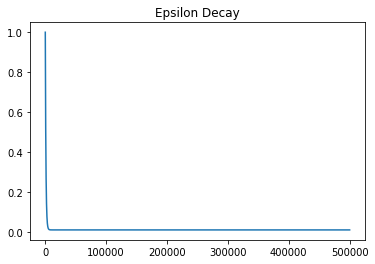

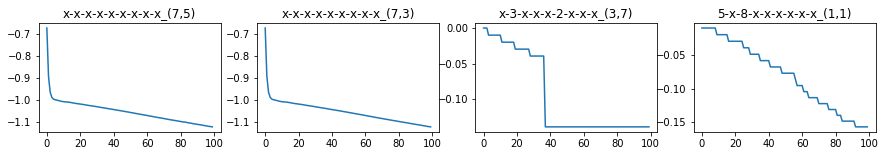

elapsed_time 314.77254986763


,win,loss,tie,episode,name
98,0.3154,0.2517,0.4329,495000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...
99,0.3157,0.2516,0.4327,500000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_0.0001
learning_rate 0.01
gamma 0.9
min_epsilon 0.01
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


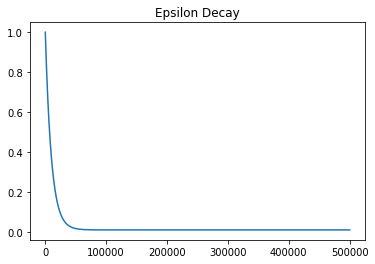

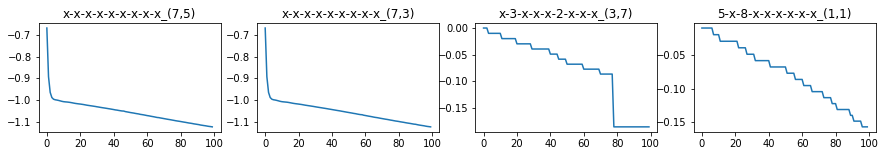

elapsed_time 299.11171317100525


,win,loss,tie,episode,name
98,0.3147,0.2526,0.4326,495000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...
99,0.3150,0.2525,0.4324,500000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_1e-05
learning_rate 0.01
gamma 0.9
min_epsilon 0.01
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


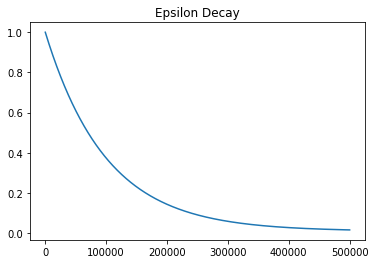

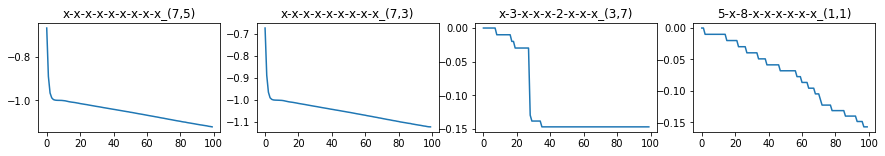

elapsed_time 313.92450976371765


,win,loss,tie,episode,name
98,0.3067,0.2565,0.4368,495000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...
99,0.3072,0.2564,0.4365,500000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_1e-06
learning_rate 0.01
gamma 0.9
min_epsilon 0.01
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


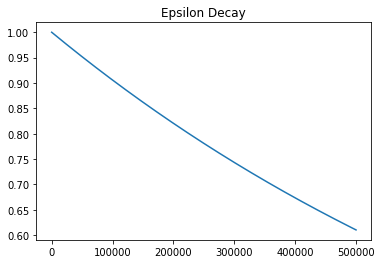

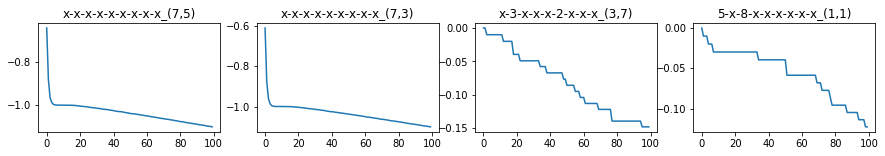

elapsed_time 384.91122817993164


,win,loss,tie,episode,name
98,0.2639,0.2782,0.4579,495000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...
99,0.2642,0.2780,0.4578,500000,lr_0.01_gamma_0.9_min_epsilon_0.01_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_0.001
learning_rate 0.1
gamma 0.8
min_epsilon 0.001
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


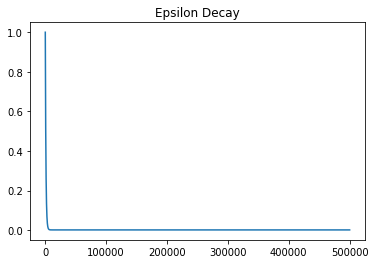

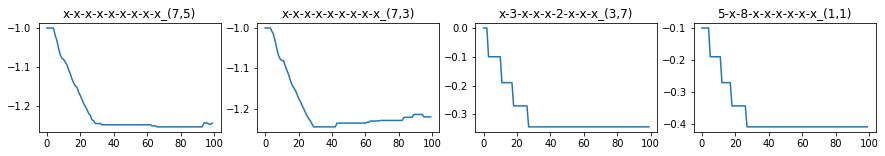

elapsed_time 216.18131303787231


,win,loss,tie,episode,name
98,0.6924,0.0995,0.2081,495000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...
99,0.6945,0.0986,0.2069,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_0.0001
learning_rate 0.1
gamma 0.8
min_epsilon 0.001
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


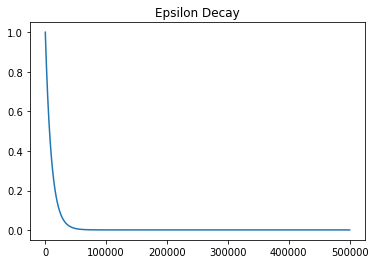

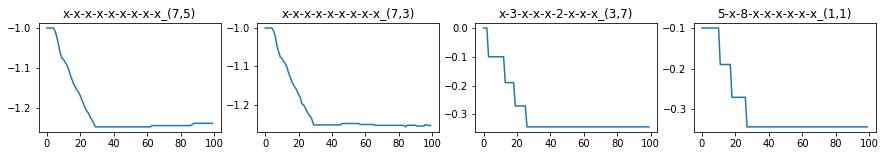

elapsed_time 220.55378699302673


,win,loss,tie,episode,name
98,0.6924,0.1037,0.2038,495000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...
99,0.6947,0.1028,0.2025,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_1e-05
learning_rate 0.1
gamma 0.8
min_epsilon 0.001
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


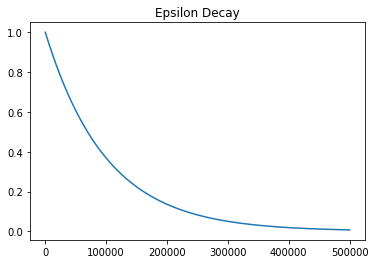

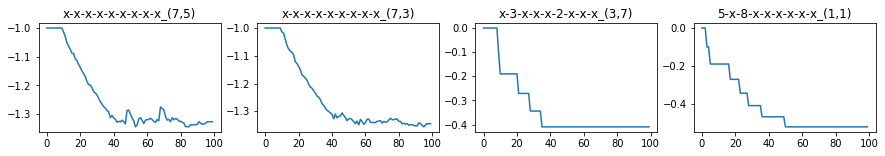

elapsed_time 263.1680181026459


,win,loss,tie,episode,name
98,0.5908,0.1497,0.2595,495000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...
99,0.5941,0.1484,0.2575,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_1e-06
learning_rate 0.1
gamma 0.8
min_epsilon 0.001
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


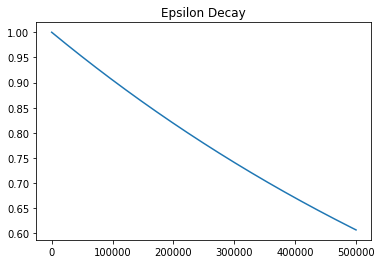

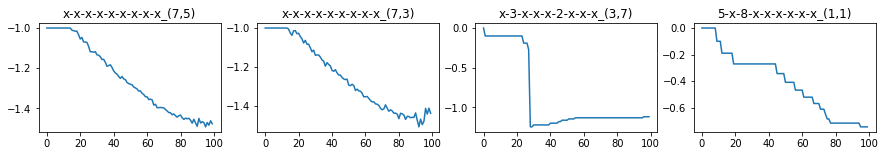

elapsed_time 357.0321500301361


,win,loss,tie,episode,name
98,0.2693,0.2755,0.4552,495000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...
99,0.2700,0.2751,0.4549,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0.001
learning_rate 0.1
gamma 0.8
min_epsilon 0.01
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


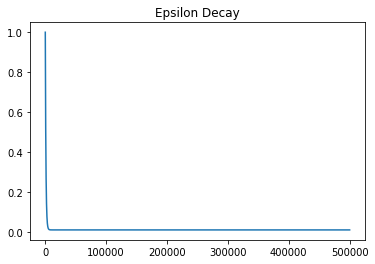

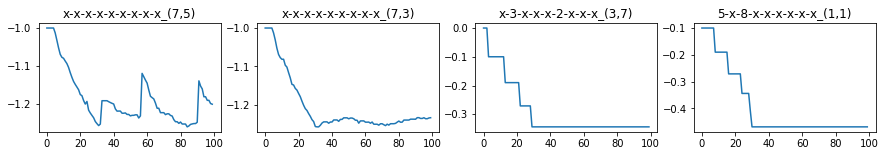

elapsed_time 224.32571601867676


,win,loss,tie,episode,name
98,0.6832,0.1073,0.2096,495000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0...
99,0.6855,0.1064,0.2081,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0.0001
learning_rate 0.1
gamma 0.8
min_epsilon 0.01
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


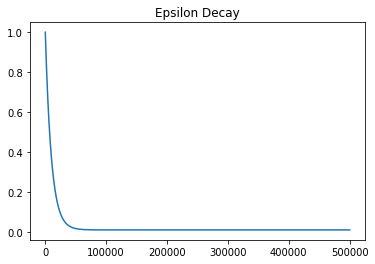

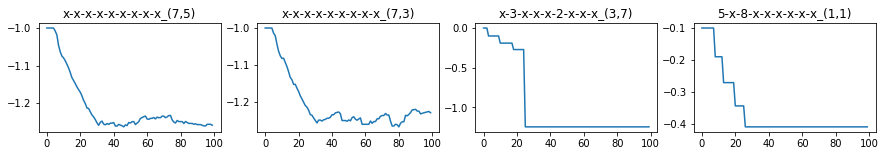

elapsed_time 220.06808495521545


,win,loss,tie,episode,name
98,0.6938,0.1080,0.1981,495000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0...
99,0.6962,0.1071,0.1966,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1e-05
learning_rate 0.1
gamma 0.8
min_epsilon 0.01
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


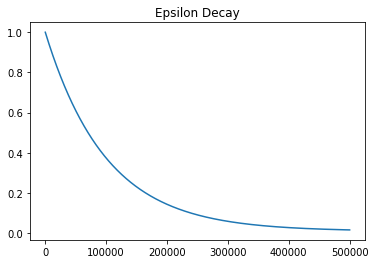

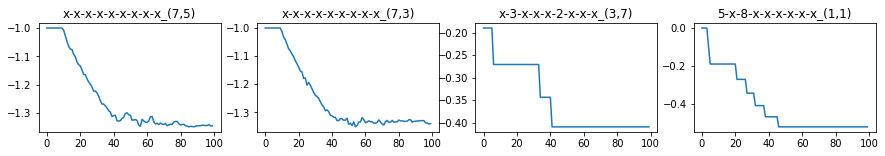

elapsed_time 258.99034309387207


,win,loss,tie,episode,name
98,0.5680,0.1550,0.2770,495000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1...
99,0.5712,0.1537,0.2751,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1...


***********************************************
Starting training for  lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1e-06
learning_rate 0.1
gamma 0.8
min_epsilon 0.01
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


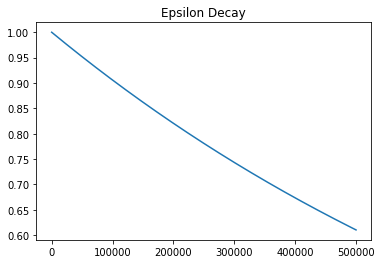

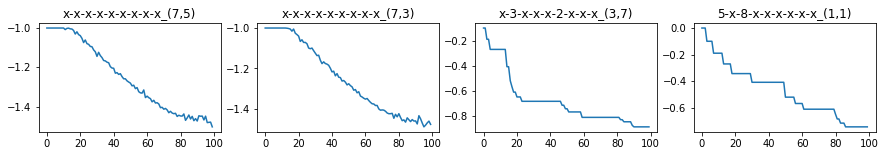

elapsed_time 363.9965319633484


,win,loss,tie,episode,name
98,0.2691,0.2753,0.4556,495000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1...
99,0.2697,0.2750,0.4553,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_1...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_0.001
learning_rate 0.1
gamma 0.9
min_epsilon 0.001
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


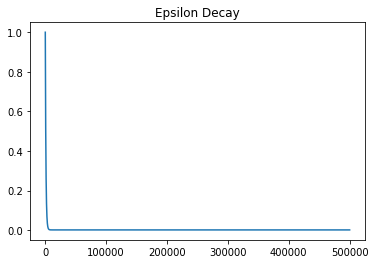

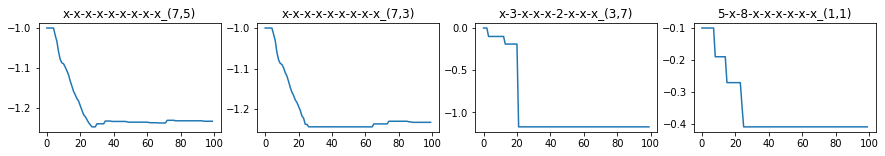

elapsed_time 196.66325211524963


,win,loss,tie,episode,name
98,0.7227,0.0935,0.1837,495000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...
99,0.7247,0.0927,0.1825,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_0.0001
learning_rate 0.1
gamma 0.9
min_epsilon 0.001
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


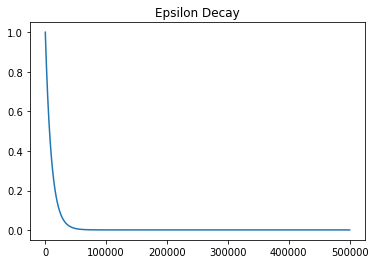

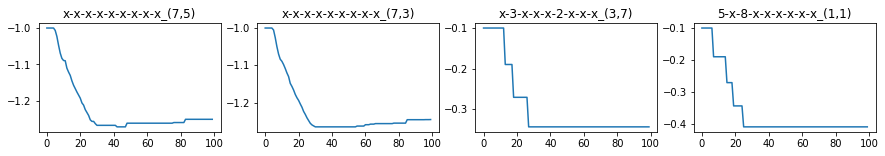

elapsed_time 203.37997007369995


,win,loss,tie,episode,name
98,0.7174,0.0956,0.1870,495000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...
99,0.7196,0.0948,0.1856,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_1e-05
learning_rate 0.1
gamma 0.9
min_epsilon 0.001
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


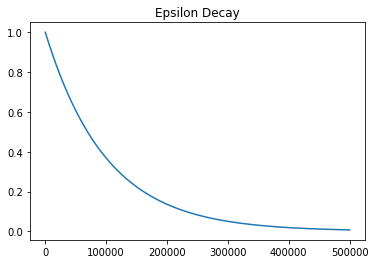

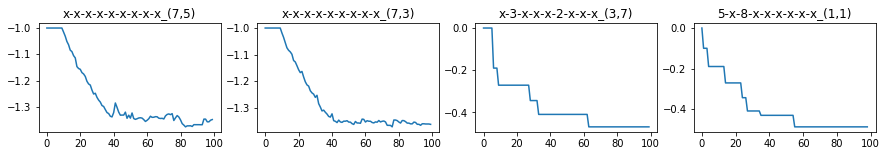

elapsed_time 238.21970105171204


,win,loss,tie,episode,name
98,0.6098,0.1453,0.2449,495000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...
99,0.6130,0.1440,0.2430,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_1e-06
learning_rate 0.1
gamma 0.9
min_epsilon 0.001
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


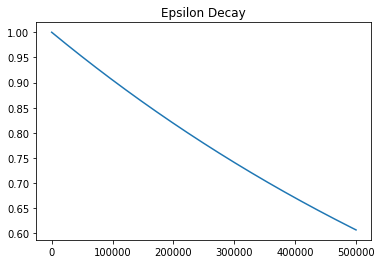

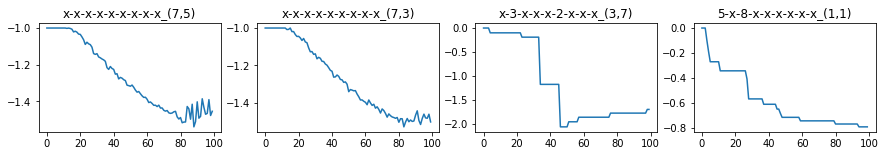

elapsed_time 355.4034640789032


,win,loss,tie,episode,name
98,0.2719,0.2746,0.4535,495000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...
99,0.2725,0.2742,0.4532,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0.001
learning_rate 0.1
gamma 0.9
min_epsilon 0.01
decay_rate 0.001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


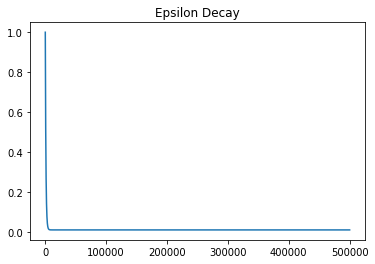

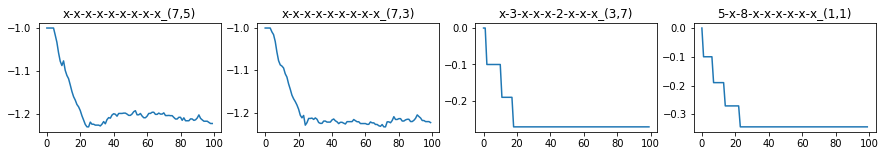

elapsed_time 196.90968322753906


,win,loss,tie,episode,name
98,0.7377,0.0932,0.1691,495000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0...
99,0.7396,0.0925,0.1679,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0.0001
learning_rate 0.1
gamma 0.9
min_epsilon 0.01
decay_rate 0.0001
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


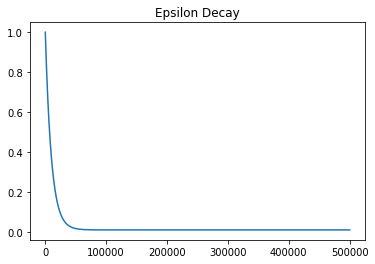

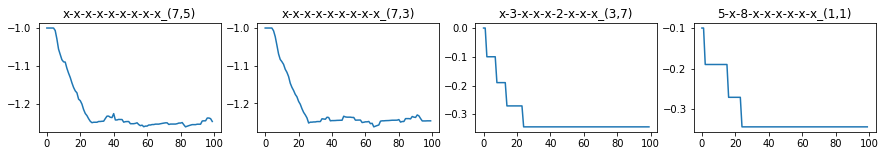

elapsed_time 201.91338300704956


,win,loss,tie,episode,name
98,0.7038,0.1019,0.1943,495000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0...
99,0.7058,0.1011,0.1931,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1e-05
learning_rate 0.1
gamma 0.9
min_epsilon 0.01
decay_rate 1e-05
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


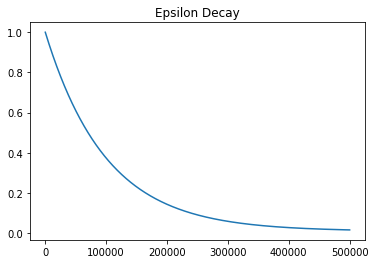

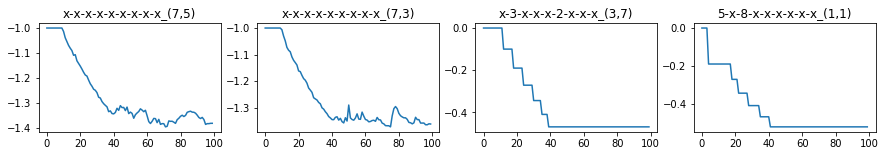

elapsed_time 241.95904803276062


,win,loss,tie,episode,name
98,0.5948,0.1490,0.2561,495000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1...
99,0.5981,0.1478,0.2541,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1...


***********************************************
Starting training for  lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1e-06
learning_rate 0.1
gamma 0.9
min_epsilon 0.01
decay_rate 1e-06
max_epsilon 1.0
number of episodes 500000
log_threshold 5000.0
threshold 5000.0
policy_threshold 50000.0


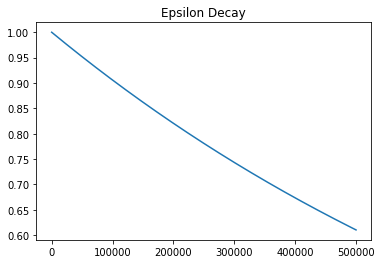

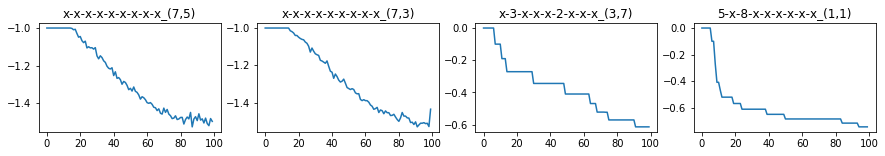

elapsed_time 354.41605401039124


,win,loss,tie,episode,name
98,0.2715,0.2754,0.4531,495000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1...
99,0.2721,0.2751,0.4527,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1...


***********************************************


In [19]:
EPISODES = 500000
for params in hp_params:
    print("Starting training for ", get_model_name(params))
    df, Q_dict, States_track = q_learning(params=params,
                                          episodes=EPISODES,
                                          verbose=False)
    display(df.tail(2))

    collect_stats(df)
    print("***********************************************")

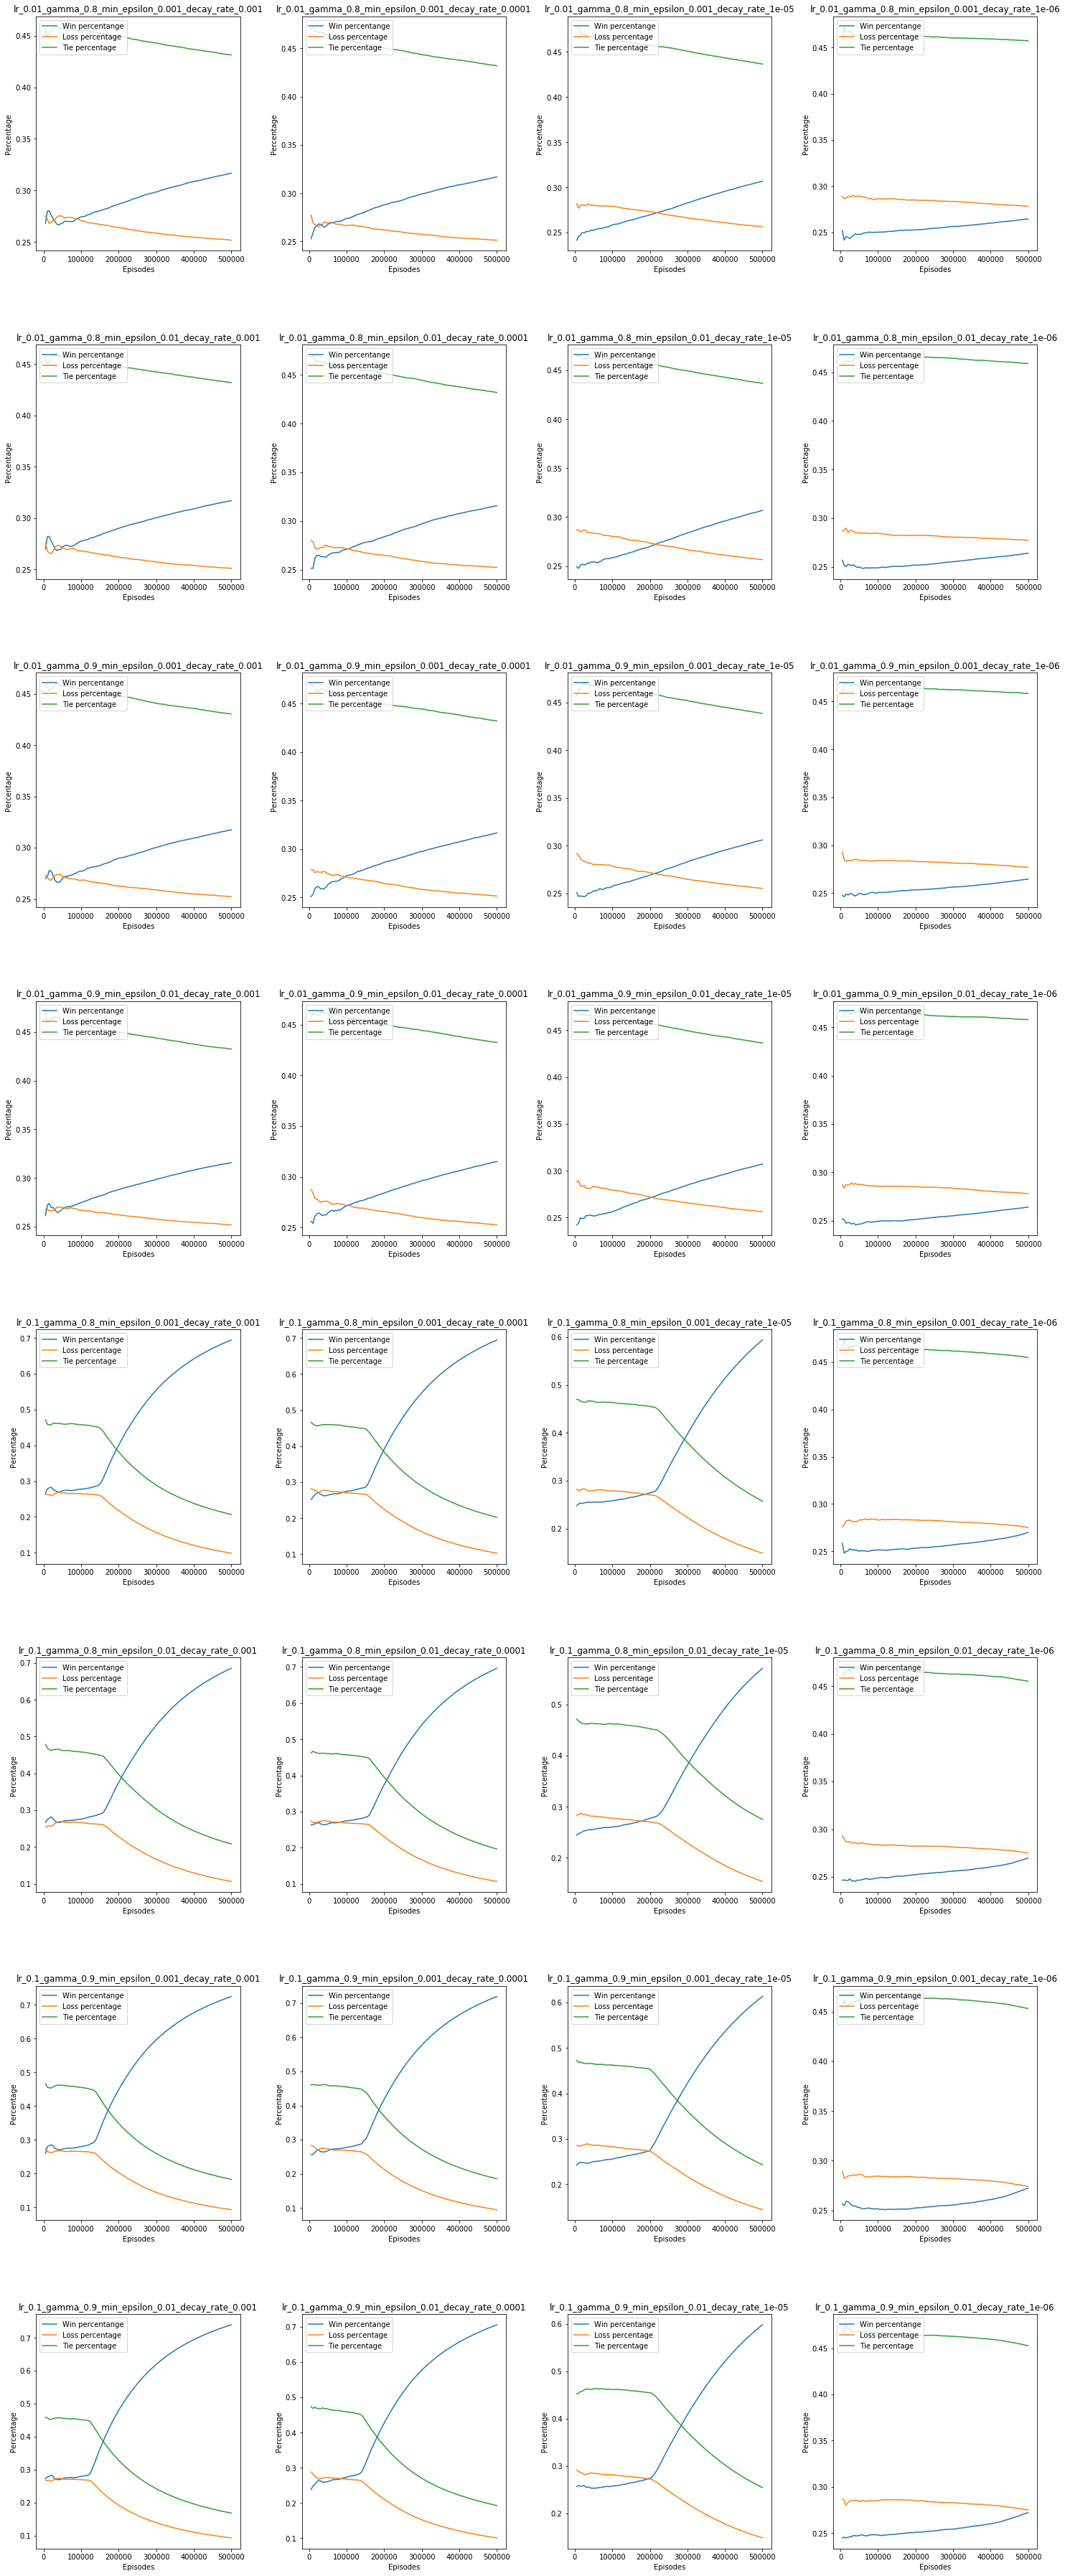

In [20]:
rows = 8
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(25, 50))

for index, params in enumerate(hp_params):
    name = get_model_name(params)

    plt.subplot(rows, columns, index + 1, title=name)

    model_data = stats.loc[stats['name'] == name]
    plt.plot(model_data['episode'],
             model_data['win'],
             label='Win percentange')
    plt.plot(model_data['episode'],
             model_data['loss'],
             label='Loss percentage')
    plt.plot(model_data['episode'],
             model_data['tie'],
             label='Tie percentage')

    plt.title(name)
    plt.ylabel('Percentage')
    plt.xlabel('Episodes')
    plt.legend(loc="upper left")

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.3)
plt.savefig('models_{}.png'.format(EPISODES))
plt.show()

In [32]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

df1 = stats.sort_values('win', ascending=False).groupby('name').head(1)
display(df1)

,win,loss,tie,episode,name
99,0.7396,0.0925,0.1679,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0.001
99,0.7247,0.0927,0.1825,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_0.001
99,0.7196,0.0948,0.1856,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_0.0001
99,0.7058,0.1011,0.1931,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_0.0001
99,0.6962,0.1071,0.1966,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0.0001
99,0.6947,0.1028,0.2025,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_0.0001
99,0.6945,0.0986,0.2069,500000,lr_0.1_gamma_0.8_min_epsilon_0.001_decay_rate_0.001
99,0.6855,0.1064,0.2081,500000,lr_0.1_gamma_0.8_min_epsilon_0.01_decay_rate_0.001
99,0.6130,0.1440,0.2430,500000,lr_0.1_gamma_0.9_min_epsilon_0.001_decay_rate_1e-05
99,0.5981,0.1478,0.2541,500000,lr_0.1_gamma_0.9_min_epsilon_0.01_decay_rate_1e-05


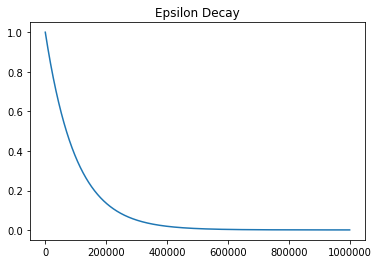

In [45]:
plot_epsilon_decay(episodes=1000000,
                   max_epsilon=1.0,
                   min_epsilon=0.001,
                   decay_rate=0.00001)

#### Check the Q-dictionary

In [ ]:
Q_dict

In [ ]:
len(Q_dict)

In [ ]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
max(Q_dict['x-x-x-x-x-x-x-x-x'],key=Q_dict['x-x-x-x-x-x-x-x-x'].get)

#### Check the states tracked for Q-values convergence
(non-evaluative)